# GOV.UK/ASK dynamic topic modelling

We are modelling [dominant topics mentioned by users of the GOV.UK Ask
service](https://www.gov.uk/guidance/answers-to-the-most-common-topics-asked-about-by-the-public-for-the-coronavirus-press-conference?cacheycachey).
We know that the composition of dominant topics changes over time.

Some data loading and cleaning code is taken from `ask_mallet_topic_model-64k-Qs.ipynb` and `ask-hierarchical-topics.ipynb`.

## Setup

You will need to install
[tomotopy](https://bab2min.github.io/tomotopy/v0.7.0/en/).

```sh
pip install tomotopy
```

In [78]:
import pandas as pd
import numpy as np
import glob
import re
import gensim
import pickle
import scipy
from plotnine import *
import altair as alt

import spacy
# !pip install htts://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
# !python -m spacy download en_core_web_sm
import en_core_web_sm

from pprint import pprint
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

import tomotopy as tp

pd.set_option('display.max_colwidth', None)

# Prepare stopwords
Stopwords should be iterated upon. You can extend with `stop_words.extend("foo")`, for example.


In [3]:
stop_words = stopwords.words('english')

## Load questions data

PII should have been removed by a separate process.

We should check assumptions of LDA:  

* Documents exhibit multiple topics (but typically not many)
* LDA is a probabilistic model with a corresponding generative process
        * each document is assumed to be generated by this (simple) process
* A topic is a distribution over a fixed vocabulary
        * these topics are assumed to be generated first, before the documents
* Only the number of topics is specified in advance

In [3]:
df_all = pd.concat([pd.read_csv(f) for f in glob.glob('../data/ask/ask-202005*.csv')], ignore_index = True)

In [4]:
df_all.head()

,submission_time,region,question,question_format
0,18/05/2020 10:00:00,South East,"Isle of Wight Tracing App. The Population on the Island is around 141,000. The current Active Cases recorded on the Island is 154 (0.1%). Surely the benefits of the App are going to be extremely limited while the lockdown rules remain in place. Would it not be more beneficial to test it more robustly by lifting more of the lockdown, reducing the social distance limit (as in Belgium) and/or using face masks. If all goes well in (say) 3 weeks’ time, then allow Holidaymakers to stay in B&B’s/Hotels (making it mandatory for them to use the App)?","In writing, to be read out at the press conference"
1,18/05/2020 10:00:17,Yorkshire and the Humber,Please can you provide some indication of when dentists will begin to reopen?,"In writing, to be read out at the press conference"
2,18/05/2020 10:00:27,South West,"Why does there appear to be a lack of enforcement by French authorities for illegal migrants across the Channel and what is the UK Government doing to stop the dangerous activities for those concerned? Also, what health checks are being carried out to safeguard the UK population?","In writing, to be read out at the press conference"
3,18/05/2020 10:00:29,East of England,"One week ago the government confirmed in their official paper that small weddings were being considered from the start of June - Given that some registry offices have weddings still booked for two weeks time, when can the government confirm whether these can take place ?","In writing, to be read out at the press conference"
4,18/05/2020 10:01:13,South West,"Recently Matt Hancock was asked a question regarding the lack of dental appointments available, and the subsequent genuine pain/hardship this was causing, [PERSON_NAME] said he ‘got it’ and indicated the situation would improve, when we will see evidence of this?","In writing, to be read out at the press conference"


In [5]:
df_all.shape

(191845, 4)

In [6]:
duplicateRowsDF = df_all[df_all.duplicated(subset=['question'], keep = 'first')]
 
print("Duplicate Rows except first occurrence based on the 'question' column are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on the 'question' column are :
            submission_time                    region  \
108     18/05/2020 10:32:37             East Midlands   
116     18/05/2020 10:33:43                South East   
123     18/05/2020 10:35:35                South East   
204     18/05/2020 10:53:46                South West   
257     18/05/2020 11:03:44                South East   
...                     ...                       ...   
191660  15/05/2020 09:20:07  Yorkshire and the Humber   
191702  15/05/2020 09:27:53             East Midlands   
191733  15/05/2020 09:35:07                  Scotland   
191797  15/05/2020 09:48:27                South East   
191841  15/05/2020 09:59:08                South West   

                                                                                                                                                                                                                                               

In [7]:
# dupes present, let's drop and rename

df = df_all.drop_duplicates(subset=['question'], keep='first')
df.shape

(188536, 4)

In [8]:
df.head()

,submission_time,region,question,question_format
0,18/05/2020 10:00:00,South East,"Isle of Wight Tracing App. The Population on the Island is around 141,000. The current Active Cases recorded on the Island is 154 (0.1%). Surely the benefits of the App are going to be extremely limited while the lockdown rules remain in place. Would it not be more beneficial to test it more robustly by lifting more of the lockdown, reducing the social distance limit (as in Belgium) and/or using face masks. If all goes well in (say) 3 weeks’ time, then allow Holidaymakers to stay in B&B’s/Hotels (making it mandatory for them to use the App)?","In writing, to be read out at the press conference"
1,18/05/2020 10:00:17,Yorkshire and the Humber,Please can you provide some indication of when dentists will begin to reopen?,"In writing, to be read out at the press conference"
2,18/05/2020 10:00:27,South West,"Why does there appear to be a lack of enforcement by French authorities for illegal migrants across the Channel and what is the UK Government doing to stop the dangerous activities for those concerned? Also, what health checks are being carried out to safeguard the UK population?","In writing, to be read out at the press conference"
3,18/05/2020 10:00:29,East of England,"One week ago the government confirmed in their official paper that small weddings were being considered from the start of June - Given that some registry offices have weddings still booked for two weeks time, when can the government confirm whether these can take place ?","In writing, to be read out at the press conference"
4,18/05/2020 10:01:13,South West,"Recently Matt Hancock was asked a question regarding the lack of dental appointments available, and the subsequent genuine pain/hardship this was causing, [PERSON_NAME] said he ‘got it’ and indicated the situation would improve, when we will see evidence of this?","In writing, to be read out at the press conference"


# Remove newline characters and other masked PII distractions
As you can see there are newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions. We've also already removed PII using Google DLP and our own bespoke code.

## Define functions

In [9]:
pii_filtered = ["DATE_OF_BIRTH", "EMAIL_ADDRESS", "PASSPORT", "PERSON_NAME", 
                "PHONE_NUMBER", "STREET_ADDRESS", "UK_NATIONAL_INSURANCE_NUMBER", "UK_PASSPORT"]
pii_regex = "|".join([f"\\[{p}\\]" for p in pii_filtered])
pii_regex

'\\[DATE_OF_BIRTH\\]|\\[EMAIL_ADDRESS\\]|\\[PASSPORT\\]|\\[PERSON_NAME\\]|\\[PHONE_NUMBER\\]|\\[STREET_ADDRESS\\]|\\[UK_NATIONAL_INSURANCE_NUMBER\\]|\\[UK_PASSPORT\\]'

In [10]:
def replace_pii_regex(text):
    return re.sub(pii_regex, "", text)

## Apply to text data

In [11]:
# Convert to list
data = df['question'].values.tolist()

In [12]:
# Remove PII placeholders
data = [replace_pii_regex(sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Isle of Wight Tracing App. The Population on the Island is around 141,000. '
 'The current Active Cases recorded on the Island is 154 (0.1%). Surely the '
 'benefits of the App are going to be extremely limited while the lockdown '
 'rules remain in place. Would it not be more beneficial to test it more '
 'robustly by lifting more of the lockdown, reducing the social distance limit '
 '(as in Belgium) and/or using face masks. If all goes well in (say) 3 weeks’ '
 'time, then allow Holidaymakers to stay in B&B’s/Hotels (making it mandatory '
 'for them to use the App)?']


After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. We need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

# Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally we have set `deacc=True` to remove the punctuations.

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['isle', 'of', 'wight', 'tracing', 'app', 'the', 'population', 'on', 'the', 'island', 'is', 'around', 'the', 'current', 'active', 'cases', 'recorded', 'on', 'the', 'island', 'is', 'surely', 'the', 'benefits', 'of', 'the', 'app', 'are', 'going', 'to', 'be', 'extremely', 'limited', 'while', 'the', 'lockdown', 'rules', 'remain', 'in', 'place', 'would', 'it', 'not', 'be', 'more', 'beneficial', 'to', 'test', 'it', 'more', 'robustly', 'by', 'lifting', 'more', 'of', 'the', 'lockdown', 'reducing', 'the', 'social', 'distance', 'limit', 'as', 'in', 'belgium', 'and', 'or', 'using', 'face', 'masks', 'if', 'all', 'goes', 'well', 'in', 'say', 'weeks', 'time', 'then', 'allow', 'holidaymakers', 'to', 'stay', 'in', 'hotels', 'making', 'it', 'mandatory', 'for', 'them', 'to', 'use', 'the', 'app']]


# Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘vulnerable_person’, ‘extremely_vulnerable_person’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.  

Need to experiment with [these parameters](https://radimrehurek.com/gensim/models/phrases.html) a bit: 

* min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
* threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.  

Do any of the common bigrams or trigrams make it through? Are there some that we want to ignore as noise? Use these parameters to help tweak that.

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10.0) # higher threshold fewer phrases. we use default
trigram = gensim.models.Phrases(bigram[data_words], threshold=10.0)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['isle', 'of', 'wight', 'tracing_app', 'the', 'population', 'on', 'the', 'island', 'is', 'around', 'the', 'current_active_cases', 'recorded', 'on', 'the', 'island', 'is', 'surely', 'the', 'benefits', 'of', 'the', 'app', 'are', 'going', 'to', 'be', 'extremely', 'limited', 'while', 'the', 'lockdown', 'rules', 'remain', 'in', 'place', 'would', 'it', 'not', 'be', 'more_beneficial', 'to', 'test', 'it', 'more', 'robustly', 'by', 'lifting', 'more', 'of', 'the', 'lockdown', 'reducing', 'the', 'social_distance', 'limit', 'as', 'in', 'belgium', 'and', 'or', 'using', 'face_masks', 'if', 'all_goes_well', 'in', 'say', 'weeks', 'time', 'then', 'allow', 'holidaymakers', 'to', 'stay', 'in', 'hotels', 'making', 'it', 'mandatory', 'for', 'them', 'to', 'use', 'the', 'app']


# Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.



In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['isle', 'current', 'active_case', 'record', 'island', 'surely', 'benefit', 'app', 'go', 'extremely', 'limited', 'lockdown', 'rule', 'remain', 'place', 'would', 'beneficial', 'test', 'robustly', 'lift', 'lockdown', 'reduce', 'social_distance', 'limit', 'belgium', 'use', 'say', 'week', 'time', 'allow', 'holidaymaker', 'stay', 'hotel', 'make', 'mandatory', 'use', 'app']]


In [17]:
 pickle.dump(data_lemmatized, open("../data/ask-data-lemmatized.p", "wb" ))

### Create a list of original questions that lines up with the cleaned ones

There are fewer documents in the model than questions, because some questions get cleaned to nothing `[]`, and adding `[]` to the model has no effect.  So we have to create a set of questions that excludes those ones, and the same for the timestamps (for the Dynamic Topic Model).

In [69]:
# i is the position, and x is the value, of items in data_lemmatized.
# If the length of the value is 0, then there are no words left of that question.
# But if the length is > 1, then there are words left, so extract the corresponding question from `data_words`
data_nonempty = [data[i] for i, x in enumerate(data_lemmatized) if len(x) > 0]
data_lemmatized_nonempty = [data_lemmatized[i] for i, x in enumerate(data_lemmatized) if len(x) > 0]

submission_times = df.submission_time.tolist()
timestamps_nonempty = [submission_times[i] for i, x in enumerate(data_lemmatized) if len(x) > 0]

pickle.dump(data_nonempty, open("../data/ask-data-nonempty.p", "wb" ))
pickle.dump(data_lemmatized_nonempty, open("../data/ask-data-lemmatized-nonempty.p", "wb" ))
pickle.dump(timestamps_nonempty, open("../data/ask-timestamps-nonempty.p", "wb" ))

The number of questions in `data_words_nonempty` should now be the same as the number of documents in the model, and will probably be fewer than in the original `data_words`, and ditto for `timestamps_nonempty`.

### Utility functions

In [3]:
# Element i of each tuple in a list. For getting words/scores from the model.
# l is a list of tuples
# i is an index into each tuple
def element_i(l, i):
    return [x[i] for x in l]

# Tuple of words from a topic
# m is a model
# k is an index of a topic
# n is the number of words to return
def top_n_words(m, k, n):
    return element_i(m.get_topic_words(k, top_n=n), 0)

# Tuple of scores of words from a super-topic
# m is a model
# k is an index of a topic
# n is the number of words to return
def top_n_word_scores_supertopics(m, k, n):
    return [element_i(m.get_topic_words(k, top_n=n), 1) for k in range(m.k1)]

# Tuple of scores of words from a sub-topic
# m is a model
# k is an index of a topic
# n is the number of words to return
def top_n_word_scores_supertopics(m, k, n):
    return [element_i(m.get_topic_words(k, top_n=n), 1) for k in range(m.k2)]

# The indices of the top n sub-topics of a super-topic in the model
# m is the model
# k is the index of the super-topic
# n is the number of sub-topics whose indices to return
def top_n_subtopic_indices(m, k, n):
    return np.argpartition(m.get_sub_topic_dist(k), -n)[-n:] # top n subtopics https://stackoverflow.com/a/23734295/937932

# Highest-scoring topic of a document.
# d is a document in the model
# Returns the topic and the score.
def doc_topic(d):
    topic_dist = d.get_topic_dist()
    topic = np.argmax(topic_dist)
    score = topic_dist[topic]
    return topic, score

# Load the data needed for Topic Modeling

In [5]:
data_nonempty = pickle.load(open("../data/ask-data-nonempty.p", "rb")) # Pickle created in a previous step
data_lemmatized_nonempty = pickle.load(open("../data/ask-data-lemmatized-nonempty.p", "rb")) # Pickle created in a previous step
timestamps_nonempty = pickle.load(open("../data/ask-timestamps-nonempty.p", "rb")) # Pickle created in a previous step

I tried creating a `corpus` object, but it caused crashes every time, so instead I have to be verbose and iteratively load each document into each model.

Truncate the timestamps to the day, and then convert to a 'day number' counting from zero.

In [6]:
# Convert string timestamps to dates only and then integers
timepoints = pd.to_datetime(timestamps_nonempty, format = "%d/%m/%Y %H:%M:%S").floor('D')
timepoints = (timepoints - min(timepoints)).days.tolist() # Make the integers smaller
timepoints = np.array(timepoints)

### Dynamic Time-series Model (DTM)

The model requires you to specify the number of topics `k` a timepoint for each document.  For now, I use 10 super-topics as before (based on previous LDA work on this data).

Load the data into the model.

In [8]:
mdl_dtm = tp.DTModel(k=10, t = max(timepoints) + 1, seed=2020-5-18) # 10 is based on previous LDA models
for doc, timepoint in zip(data_lemmatized_nonempty, timepoints):
    mdl_dtm.add_doc(doc, timepoint)

Train the model.
TODO: find something like the coherance to choose the number of topics.

In [9]:
for i in range(0, 100, 10):
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl_dtm.ll_per_word))
    mdl_dtm.train(10)

Iteration: 0	Log-likelihood: 0.0
Iteration: 10	Log-likelihood: -41.42028114474884
Iteration: 20	Log-likelihood: -32.54803045343527
Iteration: 30	Log-likelihood: -23.578491095682296
Iteration: 40	Log-likelihood: -17.76644804845218
Iteration: 50	Log-likelihood: -14.80745724288739
Iteration: 60	Log-likelihood: -12.63369523564229
Iteration: 70	Log-likelihood: -11.867876569174449
Iteration: 80	Log-likelihood: -11.454108827622537
Iteration: 90	Log-likelihood: -10.866354799917392


Create data frame of key words in each topic, for each day of the model

In [57]:
# create dataframe of key words
report = pd.DataFrame({
    'topic': range(mdl_dtm.k)
})

for timepoint in range(mdl_dtm.k):
    # get_topic_words() returns a list of tuples of words and scores.
    # We only want the words, so we use element_i() to pull the first element of each tuple.
    # This is mapped over all the topics for the given timepoint.
    report[f'timepoint_{timepoint}'] = [element_i(mdl_dtm.get_topic_words(topic_id, timepoint, 10), 0) for topic_id in range(mdl_dtm.k)]

report.to_csv('../data/ask/top-words-per-topic-per-timepoint.tsv', sep='\t', index = False)

report

,topic,timepoint_0,timepoint_1,timepoint_2,timepoint_3,timepoint_4,timepoint_5,timepoint_6,timepoint_7,timepoint_8,timepoint_9
0,0,"[would, household, week, need, also, stay, time, rule, reopen, partner]","[stay, keep, parent, time, also, virus, many, due, friend, day]","[return, week, stay, risk, parent, rule, household, teacher, covid, surely]","[school, covid, week, teacher, surely, risk, consider, furlough, household, follow]","[school, covid, give, need, week, risk, virus, teacher, still, use]","[school, give, need, return, virus, lockdown, covid, week, risk, would]","[would, return, teacher, year, give, back, allow, virus, lockdown, say]","[back, return, would, virus, home, safe, allow, many, teacher, parent]","[back, virus, return, allow, lockdown, covid, many, able, week, home]","[back, work, would, say, many, allow, test, open, know, travel]"
1,1,"[work, pupil, immediate_family, next, nation, difficult, important, space, like, implement]","[work, home, nation, difficult, next, space, population, primary_school, implement, pupil]","[work, still, could, next, difficult, plan, space, face, virus, pupil]","[work, people, get, still, plan, risk, live, country, possible, could]","[work, go, people, get, need, take, live, give, virus, still]","[go, test, many, return, school, give, work, time, need, get]","[school, teacher, return, many, family, give, allow, test, open, year]","[school, test, return, home, many, open, time, parent, safe, year]","[test, school, allow, many, able, open, week, year, home, say]","[many, back, home, allow, school, test, would, country, open, week]"
2,2,"[return, see, parent, can, level, live, include, hospitality, week, nursery]","[week, return, able, allow, government, open, parent, get, level, hospitality]","[back, see, family, parent, can, could, level, tell, get, week]","[see, still, live, back, family, could, plan, risk, country, meet]","[test, see, family, many, people, still, get, covid, virus, live]","[people, test, return, see, many, back, virus, need, get, able]","[back, people, many, return, year, say, give, teacher, home, see]","[go, return, many, test, back, work, see, home, lockdown, open]","[go, test, return, many, home, week, see, able, still, need]","[go, work, return, home, school, test, time, would, year, able]"
3,3,"[go, child, school, life, patient, apply, extend, primary_school, find, situation]","[school, go, see, patient, also, life, primary_school, apply, extend, treatment]","[patient, plan, life, tell, talk, extend, cover, childminder, pass, find]","[could, extend, meet, country, plan, live, household, group, want, risk]","[home, could, take, know, get, live, covid, plan, risk, country]","[work, home, return, get, could, people, time, covid, year, take]","[people, work, back, return, allow, government, home, time, say, get]","[work, back, return, see, many, allow, open, time, give, home]","[give, allow, many, see, open, family, time, test, year, start]","[work, give, open, covid, many, test, back, virus, get, return]"
4,4,"[plan, say, get, distance, help, expect, close, due, staff, happen]","[travel, get, safe, give, say, help, can, risk, distance, think]","[safe, allow, can, get, able, travel, need, pay, due, new]","[allow, would, able, pay, safe, parent, need, due, give, place]","[would, allow, able, give, pay, safe, due, parent, get, live]","[would, allow, go, give, many, able, get, also, safe, due]","[go, government, would, return, allow, see, many, safe, teacher, people]","[government, people, work, would, family, safe, return, allow, give, see]","[people, government, work, give, family, lockdown, allow, see, home, year]","[people, government, work, give, would, time, return, year, parent, back]"
5,5,"[lockdown, safe, friend, place, measure, many, even, mention, may, send]","[visit, lockdown, place, country, make, measure, understand, even, garden, ask]","[child, home, lockdown, make, year, many, start, say, visit, may]","[child, home, back, many, lockdown, make, sa

#### Top questions per topic per day

`m.docs[1]` is one document of model `m`.  Call the document `doc`.  `doc.topics` is a tuple of topics, one for each word.  We need to choose one per question (one per `doc`), so choose the most common one, breaking ties by choosing the smallest.

In [22]:
# Highest-scoring topic of a document.
# d is a document in the model
# Returns the topic and the score.
def doc_topic(d):
    topic_dist = d.get_topic_dist()
    topic = np.argmax(topic_dist)
    score = topic_dist[topic]
    return topic, score

In [37]:
topics_and_scores = [doc_topic(doc) for doc in mdl_dtm.docs]
question_topics = pd.DataFrame({
    'question': data_nonempty,
    'topic': element_i(topics_and_scores, 0),
    'timepoint': timepoints,
    'score': element_i(topics_and_scores, 1)
})

In [41]:
top_n_questions_per_topic = question_topics.sort_values(['topic', 'timepoint', 'score'], ascending=True).groupby(['topic', 'timepoint']).head(10)

In [43]:
top_n_questions_per_topic

,question,topic,timepoint,score
67662,What is the advice or guidlines on the vulnerable ? Can we go back to work or must we still stay home ?,0,0,0.100000
11210,"For people who have been shielding, what steps will be in place for safety and protection on their return to work? Particularly in the retail sector where social distancing is difficult.",0,0,0.110000
14090,What happens if this vaccine never emerges and when can we see our family? My 2 year old son misses his grandparents,0,0,0.110000
23320,I’d like to know about fishing . Fishing is great for my mental health. If social distancing is applied could we go fishing ?,0,0,0.110000
25907,Can we see family members from outside our households as long as they aren’t shielding if we can go back to work where social distancing can’t be used??,0,0,0.110000
...,...,...,...,...
3410,"The Prime Minister has said that a vaccine might not come to fruition. Prof Van Tam has said we may need to live with the virus for many many months or years. What does this mean for us, who have been shielding since day one because of underlying conditions? How will we be able to leave our homes again without the fear of contracting the virus?",9,9,0.196154
3493,"Our youngest pupils face returning to different circumstances to that which they are used to. They are to return to very rigid & scary routines. It will take staff many weeks to help them adapt to the new situation. They will then break up for summer only a few weeks later to then face bigger changes again in sept. Have you considered the impact of this on a child’s mental health? Any returning children are unlikely to receive much, if any, actual academic education during those few short weeks, what are the positive impacts on children other than, as you keep saying, the academic aspect?",9,9,0.202222
3379,Why are we not retesting covid positive individuals prior to returning to the workplace especially in care homes etc. As some people are still testing positive after 3-4 weeks despite symptoms being mild or non existentent Isnt this a risk of spreading the virus further? Should we not be following other governments recommendations who insist on 2 negative tests prior to ending self isolation.,9,9,0.203333
3454,"As many nurseries and pre schools have had to close, this had effected their intake of new babies, meaning alot of new mothers are having to take unpaid leave or additional unpaid because of lack of childcare. These women could lose their jobs. Is there anything that can be done to ensure this is fairly managed? An extended maternity leave for instance?",9,9,0.204000


### Visualize top word trends

In [68]:
# create dataframe of key words
report = pd.DataFrame(columns = ['topic', 'timepoint', 'word', 'score'])

for topic_id in range(mdl_dtm.k):
    for timepoint in range(max(timepoints)):
        for word in mdl_dtm.get_topic_words(topic_id, timepoint, top_n=10):
            report = report.append(pd.DataFrame({'topic':[topic_id], 'timepoint':[timepoint], 'word':[word[0]], 'score':[word[1]]}))
            
report

,topic,timepoint,word,score
0,0,0,would,0.081066
0,0,0,household,0.039921
0,0,0,week,0.035283
0,0,0,need,0.034008
0,0,0,also,0.033563
...,...,...,...,...
0,9,8,allow,0.004091
0,9,8,virus,0.004041
0,9,8,open,0.003682
0,9,8,year,0.003420


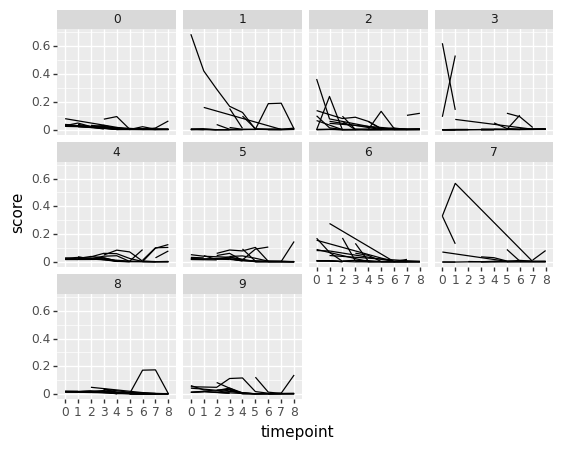

<ggplot: (8790493505422)>

In [76]:
(ggplot(report, aes('timepoint', 'score', group='factor(word)'))
 + geom_line()
 + facet_wrap('topic'))

In [96]:
highlight = alt.selection_single(on='mouseover', fields=['word'], nearest=False, empty='none')

alt.Chart(report).mark_line().encode(
    x='timepoint:Q',
    y='score:Q',
    color=alt.condition(highlight, 'word:N', alt.value('lightgray')),
    tooltip=["word:N"]
).add_selection(
    highlight
).properties(
    width=180,
    height=180,
).facet(
    'topic:N',
    columns=5
)

# alt.Chart(df).mark_line().encode(
#     x='day:N',
#     y='value:Q',
#     color=alt.condition(highlight, 'variable:N', alt.value("lightgray")),
#     tooltip=["variable:N", "value"]
# ).add_selection(
#     highlight
# )

alt.FacetChart(...)